In [263]:
import math
import pandas as pd
import numpy as np
import quandl
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import pickle
style.use('ggplot')

from sklearn import preprocessing,svm
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression

In [264]:
df = quandl.get("WIKI/GOOGL")

In [265]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [266]:
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]

In [267]:
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


In [268]:
df ['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df ['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]

In [269]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0
2004-08-20,54.322689,0.710922,7.227007,22834300.0
2004-08-23,54.869377,3.729433,-1.227880,18256100.0
2004-08-24,52.597363,6.417469,-5.726357,15247300.0
2004-08-25,53.164113,1.886792,1.183658,9188600.0


In [270]:
forecast_col = 'Adj. Close'

In [271]:
# it can be treated as an outlier if there is any missing value
df.fillna(-999999, inplace=True)

In [272]:
# forecast for next 10 days .. 
forecast_out = int(math.ceil(0.01 * len(df)))
forecast_out

35

In [273]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [274]:
X = np.array(df.drop(['label'],axis=1))
X = preprocessing.scale(X)

X = X[:-forecast_out]
X_lately = X[-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])

In [275]:
print(X.shape)
print(y.shape)

(3389, 4)
(3389,)


In [276]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [277]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2711, 4)
(2711,)
(678, 4)
(678,)


In [278]:
# n_jobs is the number of threads (jobs) for this computation. -1 means all the processors
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)

# save the model 
with open('linearRegression.pickle',  'wb') as f:
    pickle.dump(clf, f)

In [279]:
# open the model
pickle_in = open('linearRegression.pickle', 'rb')
clf = pickle.load(pickle_in)

In [280]:
accuracy = clf.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.9800395401042985


In [281]:
forecaset_set = clf.predict(X_lately)

In [282]:
print(forecaset_set, 'days:', forecast_out)

[1077.4889934  1092.18144138 1106.19941186 1100.82107465 1094.3137612
 1091.68847735 1090.15869037 1087.13127932 1080.88090116 1076.49922402
 1074.24397746 1093.63948923 1112.0183621  1116.54232839 1131.49146064
 1135.49583678 1134.17490981 1131.69673592 1133.49585535 1151.79876683
 1150.79732333 1161.12040211 1157.64680372 1165.45424495 1185.61364396
 1198.07556868 1192.21868471 1204.3249215  1209.93603884 1207.80444738
 1198.5719759  1204.26606854 1202.82248086 1138.35479128 1084.71338671] days: 35


In [283]:
df['Forecast'] = np.nan

In [284]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecaset_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix +=one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

In [285]:
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label,Forecast
Date,,,,,,
2018-03-07 18:00:00,NaN,NaN,NaN,NaN,NaN,1198.571976
2018-03-08 18:00:00,NaN,NaN,NaN,NaN,NaN,1204.266069
2018-03-09 18:00:00,NaN,NaN,NaN,NaN,NaN,1202.822481
2018-03-10 18:00:00,NaN,NaN,NaN,NaN,NaN,1138.354791
2018-03-11 19:00:00,NaN,NaN,NaN,NaN,NaN,1084.713387


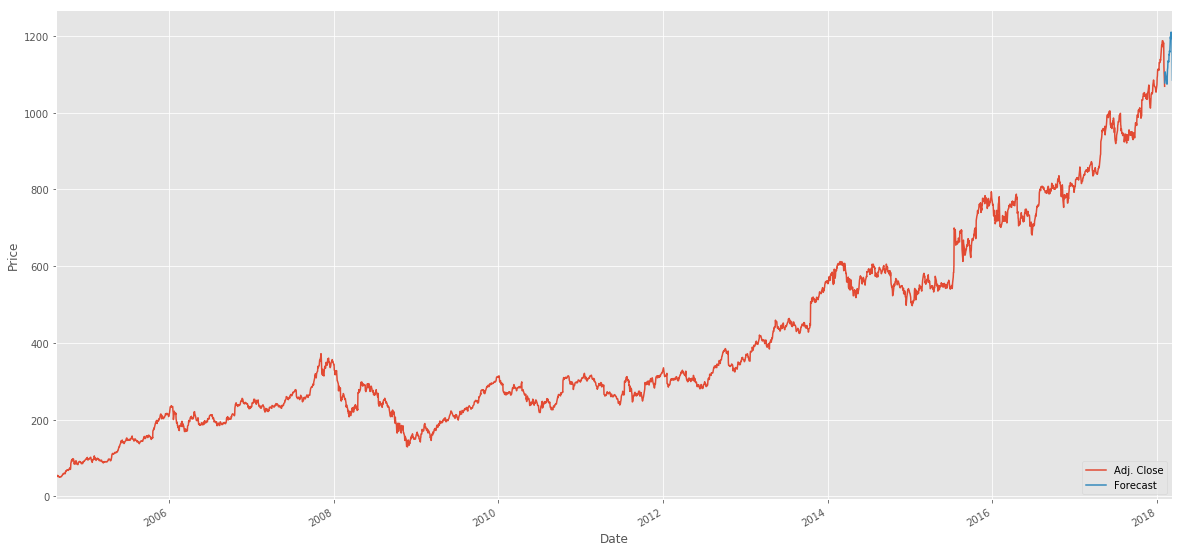

In [286]:
plt.figure(figsize=(20,10))
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show();